# MVA: basic VAE in Pytorch

# Loading useful stuff

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
import torch.distributions as td
import torch.nn.functional as F
from tqdm.notebook import tqdm

# Loading Larochelle's binary MNIST

In [2]:
xtrain = np.loadtxt('http://www.cs.toronto.edu/~larocheh/public/datasets/binarized_mnist/binarized_mnist_train.amat',dtype=np.float32).reshape(-1,28, 28,order='C')
xvalid = np.loadtxt('http://www.cs.toronto.edu/~larocheh/public/datasets/binarized_mnist/binarized_mnist_valid.amat',dtype=np.float32).reshape(-1,28, 28,order='C')
xtest = np.loadtxt('http://www.cs.toronto.edu/~larocheh/public/datasets/binarized_mnist/binarized_mnist_test.amat',dtype=np.float32).reshape(-1,28, 28,order='C')

p = 784
n = xtrain.shape[0]
ntest = xtest.shape[0]

xtrain = xtrain.reshape((-1,p))
xvalid = xvalid.reshape((-1,p))
xtest = xtest.reshape((-1,p))

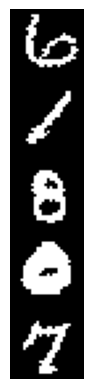

In [3]:
plt.imshow(xtrain[0:5, :].reshape((28*5,28)), cmap='gray')
plt.axis('off')
plt.show()

# Specifying our graphical model

We will use a **deep latent variable model with a Gaussian prior and a Bernoulli observation model**. This can be written:

$$p_{\boldsymbol{\theta}}(\mathbf{x}_1,...,\mathbf{x}_n) = \prod_{i=1}^n p_{\boldsymbol{\theta}}(\mathbf{x}_i|\mathbf{z}_i)p(\mathbf{z}_i),$$
$$p(\mathbf{z}_i) = \mathcal{N}(\mathbf{z}_i|\mathbf{0}_d,\mathbf{I}_d), $$
$$p_{\boldsymbol{\theta}}(\mathbf{x}_i|\mathbf{z}_i) = \mathcal{B} (\mathbf{x}_i|\boldsymbol{\pi}_{\boldsymbol{\theta}}(\mathbf{z}_i)) = \prod_{j=1}^{28 \times 28} \mathcal{B} (\mathbf{x}_{ij}|[\boldsymbol{\pi}_{\boldsymbol{\theta}}(\mathbf{z}_i)]_j),$$

where $\boldsymbol{\pi}_{\boldsymbol{\theta}}: \mathbb{R}^d \rightarrow {[0,1]}^p$ is a function (called the **decoder**) parametrised by a deep neural net. This neural net will be defined as a Pytorch sequential model.

In [4]:
d = 16 # dimension of the latent space

p_z = td.Independent(td.Normal(loc = torch.zeros(d), scale = torch.ones(d)),reinterpreted_batch_ndims=1)  # that's the prior

In [5]:
num_hidden = 50

decoder = nn.Sequential(
            nn.Linear(d, num_hidden),
            nn.ReLU(),
            nn.Linear(num_hidden, num_hidden),
            nn.ReLU(),
            nn.Linear(num_hidden, 784)
    )

Note that **the decoder needs to output probabilities**, which can be constrained using a sigmoid final layer. However, it is generally better (i.e. computationnaly more stable) to work with [logits](https://stackoverflow.com/questions/34240703/what-are-logits-what-is-the-difference-between-softmax-and-softmax-cross-entrop) than probabilities, when doing deep learning. For instance, all the distributions of TensorFlow probability or Pytorch distributions that use probabilities as parameters (e.g. [Bernoulli](https://www.tensorflow.org/probability/api_docs/python/tfp/distributions/Bernoulli), [categorical](https://www.tensorflow.org/probability/api_docs/python/tfp/distributions/Categorical) or [binomial](https://www.tensorflow.org/probability/api_docs/python/tfp/distributions/Binomial)) can use $\texttt{logits}$ or $\texttt{probs}$ as arguments. It is generally better to use  $\texttt{logits}$. This is why this keras model for the decoder does not output probabilities, but logits.





# Ancestral sampling

Let us implement ancestral sampling for our simple, two-node graphical model!

In [6]:
z_samples = p_z.sample((5,))
p_xgivenz = td.Independent(td.Bernoulli(logits = decoder(z_samples)), reinterpreted_batch_ndims = 1)
x_samples = p_xgivenz.sample((1,))

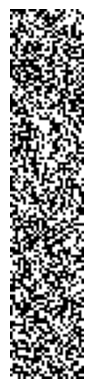

In [7]:
plt.imshow(x_samples.numpy().reshape((28*5,28)), cmap='gray')
plt.axis('off')
plt.show()

Of course, the samples look like rubbish, because the model is untrained...

## Encoder

To be able to train our model, we will need an **encoder** (aka **inference network**), that will allow us to approximate the intractable posterior $p(\mathbf{z}|\mathbf{x})$.
The approximate posterior is defined as follows
$$ q_\boldsymbol{\gamma}(\mathbf{z}|\mathbf{x}) = \mathcal{N}(\mathbf{z} | \mathbf{m}_\boldsymbol{\gamma} ( \mathbf{x} ), \text{Diag}(\mathbf{s}_\boldsymbol{\gamma} ( \mathbf{x} )),
$$
where $\mathbf{x} \mapsto (\mathbf{m}_\boldsymbol{\gamma} ( \mathbf{x} ), \mathbf{s}_\boldsymbol{\gamma} ( \mathbf{x} ))$ is a function from the data space (i.e. $\{0,1\}^p$) to $\mathbb{R}^d \times [0, \infty[^d$ parametrised by a deep neural network. In other words, **the encoder outputs the mean and the diagonal of the covariance matrix of proposal (aka approximate posterior) $q_\boldsymbol{\gamma}(\mathbf{z}|\mathbf{x})$.**

In [8]:
encoder = nn.Sequential(
            nn.Flatten(), # we flatten the images into vectors
            nn.Linear(784, num_hidden),
            nn.ReLU(),
            nn.Linear(num_hidden, num_hidden),
            nn.ReLU(),
            nn.Linear(num_hidden, d*2) # d*2 because we output both the mean of q and the diagonal of the covariance
    )

Let us now see how to sample from this approximate posterior. For instance, let us take a batch of images $x_1,\ldots,x_{n_B}$, and create the distributions $q_\boldsymbol{\gamma}(\mathbf{z}|\mathbf{x}_1),\ldots, q_\boldsymbol{\gamma}(\mathbf{z}|\mathbf{x}_{n_B})$.

In [9]:
batch = torch.tensor(xtrain[:10,:])

encoded_batch = encoder(batch)

mu_q = encoded_batch[:,:d]
sigma_q = nn.Softplus()(encoded_batch[:,d:])

q_zgivenx = td.Independent(td.Normal(loc = mu_q, scale = sigma_q) ,reinterpreted_batch_ndims=1)

We can now sample from the approximate posterior!

In [10]:
z_sample = q_zgivenx.sample((1,))

In [11]:
z_sample_reparametrised = q_zgivenx.rsample((1,))

Try to use this to train a VAE! Note that you will need reparametrised samples to compute the gradients wrt the encoder, so do not forget to use $\texttt{rsample}$ while training!

## Computing (an estimate of) the IWAE $\mathcal{L}_K$ bound

First, we will see how to compute an unbiased estimate of the IWAE bound $\mathcal{L}_K$. It is defined as $$\mathcal{L}_K = \mathbb{E} \left[ \frac{1}{n}\sum_{i=1}^n  \log \left( \frac{1}{K} \sum_{k=1}^K \frac{p(x_i |z_{ik}) p(z_{ik})}{q_i(z_{ik})}\right) \right].$$

The standard way to do so is just to sample $z_{i1}, \ldots, z_{iK} \sim q(z |x_i)$ for each data point $i$, and then do a Monte Carlo estimate of the expectation. The estimate is then simply
$$\mathcal{L}_K \approx\frac{1}{n} \sum_{i=1}^n  \log \left( \frac{1}{K} \sum_{k=1}^K \frac{p(x_i |z_{ik}) p(z_{ik})}{q_i(z_{ik})}\right).$$

An efficient way to compute this is using the [logsumexp trick](https://en.wikipedia.org/wiki/LogSumExp), readily implemented in Pytorch via $\texttt{torch.logsumexp}$

In [12]:
K = 5

batch = torch.tensor(xtrain[:10,:])

encoded_batch = encoder(batch)

mu_q = encoded_batch[:,:d]
sigma_q = nn.Softplus()(encoded_batch[:,d:])

q_zgivenx = td.Independent(td.Normal(loc = mu_q, scale = sigma_q) ,reinterpreted_batch_ndims=1)

z = q_zgivenx.rsample((6,)) # rsample is necessary to train properly the model, but to evaluate the bound, it won't make a difference

p_xgivenz = td.Independent(td.Bernoulli(logits = decoder(z)), reinterpreted_batch_ndims = 1)

log_weights = p_xgivenz.log_prob(batch) + p_z.log_prob(z) - q_zgivenx.log_prob(z)

iwae_bound = torch.mean(torch.logsumexp(log_weights,0) - torch.log(torch.tensor(K)))
print(iwae_bound.detach().numpy())

-545.3472


One can see that there is a significant amount of randomness. We can also check that the bound is getting higher with more samples

In [13]:
K = 50

batch = torch.tensor(xtrain[:10,:])

encoded_batch = encoder(batch)

mu_q = encoded_batch[:,:d]
sigma_q = nn.Softplus()(encoded_batch[:,d:])

q_zgivenx = td.Independent(td.Normal(loc = mu_q, scale = sigma_q) ,reinterpreted_batch_ndims=1)

z = q_zgivenx.rsample((6,)) # rsample is necessary to train properly the model, but to evaluate the bound, it won't make a difference

p_xgivenz = td.Independent(td.Bernoulli(logits = decoder(z)), reinterpreted_batch_ndims = 1)

log_weights = p_xgivenz.log_prob(batch) + p_z.log_prob(z) - q_zgivenx.log_prob(z)

iwae_bound = torch.mean(torch.logsumexp(log_weights,0) - torch.log(torch.tensor(K)))
print(iwae_bound.detach().numpy())

-547.13904


# Training

In [15]:
device = torch.device("cuda")
decoder.to(device)
encoder.to(device)
p_z = td.Independent(td.Normal(loc = torch.zeros(d,  device= device), scale = torch.ones(d, device= device)),reinterpreted_batch_ndims=1)  # that's the prior

Now, I define my optimizer and dataloader.

In [16]:
all_parameters = list(encoder.parameters()) + list(decoder.parameters())

In [17]:
optimizer = torch.optim.Adam(all_parameters, lr=0.0002)

In [18]:
data_loader = torch.utils.data.DataLoader(xtrain, batch_size = 512) # use a smaller batch size if you run out of memory

We can finally train our IWAE. We'll just do a standard pytorch training loop.

In [19]:
epochs = 100

total_steps_progress_bar = len(data_loader)*epochs


In [20]:
progress_bar = tqdm(range(total_steps_progress_bar), desc="Training")

for epoch in range(epochs):
        data_iter = iter(data_loader)
        for batch in data_iter:
            batch = batch.to(device)
            optimizer.zero_grad()

            encoded_batch = encoder(batch)
            mu_q = encoded_batch[:,:d]
            sigma_q = nn.Softplus()(encoded_batch[:,d:])
            q_zgivenx = td.Independent(td.Normal(loc = mu_q, scale = sigma_q) ,reinterpreted_batch_ndims=1)
            z = q_zgivenx.rsample((6,))
            p_xgivenz = td.Independent(td.Bernoulli(logits = decoder(z)), reinterpreted_batch_ndims = 1)
            log_weights = p_xgivenz.log_prob(batch) + p_z.log_prob(z) - q_zgivenx.log_prob(z)

            iwae_bound = torch.mean(torch.logsumexp(log_weights,0)) - torch.log(torch.tensor(K))

            loss = - iwae_bound
            loss.backward()
            optimizer.step()

            # Update progress bar
            progress_bar.set_postfix(loss=f"⠀{loss.item():12.4f}", epoch=f"{epoch+1}/{epochs}")
            progress_bar.update()

Training:   0%|          | 0/9800 [00:00<?, ?it/s]

Let's now use this trained model to sample new images!

In [21]:
z_samples = p_z.sample((5,))
p_xgivenz = td.Independent(td.Bernoulli(logits = decoder(z_samples)), reinterpreted_batch_ndims = 1)
x_samples = p_xgivenz.sample((1,))

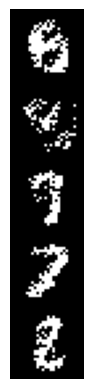

In [22]:
plt.imshow(x_samples.cpu().numpy().reshape((28*5,28)), cmap='gray')
plt.axis('off')
plt.show()